### Project: GA4-Python-Automation

In this project, my objective is to demonstrate automated generation of analytics reports using data from GA4. While GA4 generate basic reports, we aim to generate reports more advanced than default Google Analytics 4 reports by leveraging generative AI. To achieve this objective, we perform below tasks.

### Tasks planned
1. Connect and retrieve the data from Google Analytics 4 (GA4) using Google Analytics data API and perform visualisation using widely used python libraries.
2. Connect to GPT 3.5 using OpenAI API, and generate insights on data tables.
3. Generate PDF reports.
4. Connect to PowerBI using python libraries.
5. Use Github Co-pilot
6. So far, below are the tasks completed.

### Tasks completed
1. Successfully connected to GA4 and retrieve data.
2. Successully connected to GPT3.5 and generated analysis of tabular data.

#### Import required libraries

1. Import standard python libraries numpy and pandas, along viz libraries of matplotlib and seaborn. 
2. Plotly will be used at a later stage, for interactive visuals.
3. To work with date objects, import the libraries of data and timedelta from python's datetime module.
4. To interact with the Google Analytics Data API using Python, import the libraries provided by Google Analytics

In [189]:
# Data and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Date and Time libraries
from datetime import date
from datetime import timedelta
from datetime import datetime
import calendar


# Google Analytics Modules and Libraries
import os
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest
from google.analytics.data_v1beta.types import OrderBy


import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)



#### Specify a data source 
To start working with Google Analytics Data APIv1 (Beta), first [specify a data source](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#specify_a_data_source)

In [56]:
#  Point the GOOGLE_APPLICATION_CREDENTIALS environment variable to the file where credentials are located. 
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r'ga4python3-8fc10d9b3712.json'
property_id = '382343330' 

# Set up a an instance of BetaAnalyticsDataClient
client = BetaAnalyticsDataClient()

- The json file containing credentials is located in the current directory.
- r before a string denotes a raw string literal. All Backslashes are treated as literal backslashes. Useful when accessing directories with backslashes.

#### Generate a report

[To generate a report](https://developers.google.com/analytics/devguides/reporting/data/v1/basics#generate_a_report), construct a RunReportRequest object and start with the following input request parameters:

- A valid entry in the dateRanges field.
- At least one valid entry in the dimensions field.
- At least one valid entry in the metrics field.
- (optional) specify the order in which you want the data to be displayed.

In [126]:

# Specify the date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Specify the dimensions
dimensions = [
    Dimension(name='month'),
    ]

# Specify the metrics
metrics = [
        Metric(name="activeUsers"),
        Metric(name="newUsers"),
        Metric(name="sessions"),
        Metric(name="engagedSessions"),
        Metric(name="bounceRate"),            
         ]

# Specify the order in which you want the data to be returned. Sort by dimension or metric.
order_bys = [
    OrderBy(OrderBy(dimension = {'dimension_name': 'month'}, desc=False)),
    ]

In [127]:
# Create the request object with the requests parameters
request = RunReportRequest(
    property=f'properties/{property_id}',
    dimensions=dimensions,
    metrics=metrics,
    date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    order_bys=order_bys
)

# Send the request to the API   
response = client.run_report(request)


#### Explore the contents of API response object

In [151]:
print("The API response rowcount:", response.row_count)
print()

# Print dimension headers
print("The API response dimension headers:")
for header in response.dimension_headers:
    print(" ", header.name)
print()

# Print metric headers
print("The API response metric headers:")
for header in response.metric_headers:
    print(" ", header.name)
print()

# Print data rows
print("The API response data rows:")
for row in response.rows:
    dimensions = [dim.value for dim in row.dimension_values]
    metrics = [metric.value for metric in row.metric_values]
    print(" Dimensions:", dimensions, "Metrics:", metrics)

The API response rowcount: 7

The API response dimension headers:
  month

The API response metric headers:
  activeUsers
  newUsers
  sessions
  engagedSessions
  bounceRate

The API response data rows:
 Dimensions: ['06'] Metrics: ['851', '848', '1166', '779', '0.33190394511149229']
 Dimensions: ['07'] Metrics: ['1093', '1066', '1467', '913', '0.3776414451261077']
 Dimensions: ['08'] Metrics: ['1155', '1120', '1545', '957', '0.38058252427184464']
 Dimensions: ['09'] Metrics: ['1166', '1141', '1547', '936', '0.3949579831932773']
 Dimensions: ['10'] Metrics: ['1083', '1055', '1393', '857', '0.38478104809763103']
 Dimensions: ['11'] Metrics: ['1374', '1337', '1871', '1159', '0.38054516301443081']
 Dimensions: ['12'] Metrics: ['955', '914', '1237', '826', '0.33225545675020213']


#### Convert the data from response object to Dataframe

In [166]:
# Print counts of dimensions and metrics
dim_len = len(response.dimension_headers)
print(f"The number of dimensions are {dim_len}")
metric_len = len(response.metric_headers)
print(f"The number of metrics are {metric_len}")

# List to store row data
all_data = []

# Process each row in the response
for row in response.rows:
    row_data = {}  # Dictionary to store current row's data
    
    # Extract dimension values
    for i in range(dim_len):
        dim_name = response.dimension_headers[i].name  # Dimension name
        dim_value = row.dimension_values[i].value  # Dimension value
        row_data[dim_name] = dim_value
    print(row_data)
    
    # Extract metric values
    for i in range(metric_len):
        metric_name = response.metric_headers[i].name  # Metric name
        metric_value = row.metric_values[i].value  # Metric value
        row_data[metric_name] = metric_value
    print(row_data)
    
    # Add the row's data to the list
    all_data.append(row_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)

# Display the first 7 rows of the DataFrame
df.head(7)


The number of dimensions are 1
The number of metrics are 5
{'month': '06'}
{'month': '06', 'activeUsers': '851', 'newUsers': '848', 'sessions': '1166', 'engagedSessions': '779', 'bounceRate': '0.33190394511149229'}
{'month': '07'}
{'month': '07', 'activeUsers': '1093', 'newUsers': '1066', 'sessions': '1467', 'engagedSessions': '913', 'bounceRate': '0.3776414451261077'}
{'month': '08'}
{'month': '08', 'activeUsers': '1155', 'newUsers': '1120', 'sessions': '1545', 'engagedSessions': '957', 'bounceRate': '0.38058252427184464'}
{'month': '09'}
{'month': '09', 'activeUsers': '1166', 'newUsers': '1141', 'sessions': '1547', 'engagedSessions': '936', 'bounceRate': '0.3949579831932773'}
{'month': '10'}
{'month': '10', 'activeUsers': '1083', 'newUsers': '1055', 'sessions': '1393', 'engagedSessions': '857', 'bounceRate': '0.38478104809763103'}
{'month': '11'}
{'month': '11', 'activeUsers': '1374', 'newUsers': '1337', 'sessions': '1871', 'engagedSessions': '1159', 'bounceRate': '0.3805451630144308

,month,activeUsers,newUsers,sessions,engagedSessions,bounceRate
0,06,851,848,1166,779,0.33190394511149229
1,07,1093,1066,1467,913,0.3776414451261077
2,08,1155,1120,1545,957,0.38058252427184464
3,09,1166,1141,1547,936,0.3949579831932773
4,10,1083,1055,1393,857,0.38478104809763103
5,11,1374,1337,1871,1159,0.38054516301443081
6,12,955,914,1237,826,0.33225545675020213


#### Check for datatypes in the dataframe

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   month            7 non-null      object
 1   activeUsers      7 non-null      object
 2   newUsers         7 non-null      object
 3   sessions         7 non-null      object
 4   engagedSessions  7 non-null      object
 5   bounceRate       7 non-null      object
dtypes: object(6)
memory usage: 464.0+ bytes


In [168]:
df['month'] = df['month'].apply(lambda x: calendar.month_abbr[int(x)])
df[['activeUsers', 'newUsers', 'sessions', 'engagedSessions']] = df[['activeUsers', 'newUsers', 'sessions', 'engagedSessions']].astype(int)
df['bounceRate'] = df['bounceRate'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   month            7 non-null      object 
 1   activeUsers      7 non-null      int32  
 2   newUsers         7 non-null      int32  
 3   sessions         7 non-null      int32  
 4   engagedSessions  7 non-null      int32  
 5   bounceRate       7 non-null      float64
dtypes: float64(1), int32(4), object(1)
memory usage: 352.0+ bytes


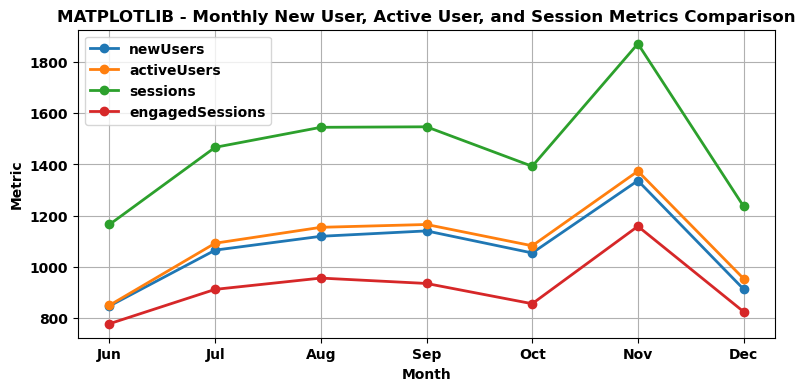

In [169]:
# Use Matplotlib to plot line graph of various metrics spread over specified period

plt.figure(figsize=(9, 4))

metrics = ['newUsers', 'activeUsers', 'sessions', 'engagedSessions'] 

# plt.plots generate matplotlib line graphs. Specify x and y axes. 
plt.plot(df['month'], df[metrics], label=metrics, marker = 'o', linewidth = 2)
plt.xlabel('Month')
plt.ylabel('Metric')
plt.title('MATPLOTLIB - Monthly New User, Active User, and Session Metrics Comparison')
plt.legend()
plt.grid(True)
plt.show()



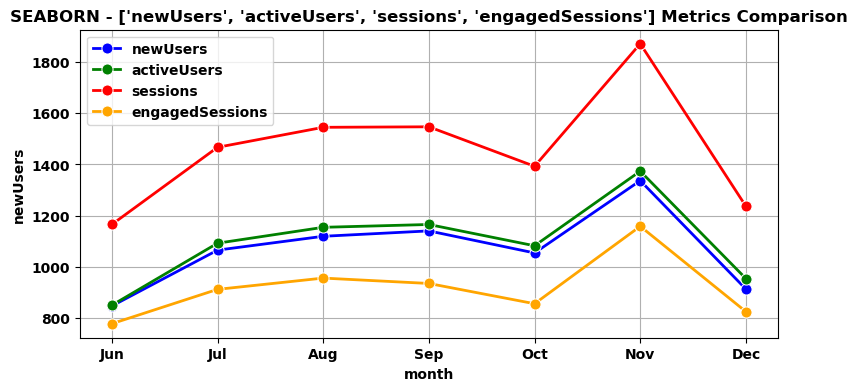

In [172]:
# Use Seaborn library to represent the same line graph as above
# Specify color choice for each metric
colors = {'newUsers': 'blue', 'activeUsers': 'green', 'sessions': 'red', 'engagedSessions': 'orange'}

plt.figure(figsize=(9, 4))
for metric in metrics: 
    sns.lineplot(data=df, x='month', y=metric, label=metric, marker = 'o', color = colors[metric], linewidth = 2, markersize = 8)
    
plt.xlabel('Month')
plt.ylabel('Metric')
plt.title(f'SEABORN - {metrics} Metrics Comparison')
plt.grid(True)
plt.show()

### Monthly New User, Active User, and Session Metrics Comparison

In [125]:
# Load data in df to excel

df.to_excel("Monthly_basic_metrics.xlsx",sheet_name = 'Basic_performance_metrics', engine = 'xlsxwriter')

- New users: The number of users who interacted with your site or launched your app for the first time (event triggered: first_open or first_visit). 

- Active users: The number of distinct users who visited your site or app.

- Sessions: The number of sessions that began on your site or app (event triggered: session_start).

### Top 15 Landing Pages by Active Users

In [204]:
# Specify the date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Specify the dimensions
dimensions = [
    Dimension(name='landingPage'),
    ]

# Specify the metrics
metrics = [
        Metric(name="activeUsers"),
        Metric(name="bounceRate"),            
         ]

# Specify the order in which you want the data to be returned. Sort by dimension or metric.
order_bys = [
    OrderBy(OrderBy(metric = {'metric_name': 'activeUsers'}, desc=True)),
    ]

date_ranges=[
    DateRange(start_date=start_date, 
              end_date=end_date,
              )
    ],


In [205]:
# Run report
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=dimensions,
        metrics=metrics,
        order_bys = order_bys,
        date_ranges=[DateRange(start_date=start_date, end_date=end_date,)],
        )

print(request)

response = client.run_report(request)

print("The API response rowcount:", response.row_count)


property: "properties/382343330"
dimensions {
  name: "landingPage"
}
metrics {
  name: "activeUsers"
}
metrics {
  name: "bounceRate"
}
date_ranges {
  start_date: "2023-01-01"
  end_date: "2023-12-31"
}
order_bys {
  metric {
    metric_name: "activeUsers"
  }
  desc: true
}

The API response rowcount: 216


In [ ]:
landing_table = format_report(landing_page_users_request)
landing_table['activeUsers'] = landing_table['activeUsers'].astype('int')

print('\nTop 1 Landing Pages and, its Bounce Rate')
display(landing_table[0:1]) 

In [206]:
# Print counts of dimensions and metrics
dim_len = len(response.dimension_headers)
print(f"The number of dimensions are {dim_len}")
metric_len = len(response.metric_headers)
print(f"The number of metrics are {metric_len}")

# List to store row data
all_data = []

# Process each row in the response
for row in response.rows:
    row_data = {}  # Dictionary to store current row's data
    
    # Extract dimension values
    for i in range(dim_len):
        dim_name = response.dimension_headers[i].name  # Dimension name
        dim_value = row.dimension_values[i].value  # Dimension value
        row_data[dim_name] = dim_value
    print(row_data)
    
    # Extract metric values
    for i in range(metric_len):
        metric_name = response.metric_headers[i].name  # Metric name
        metric_value = row.metric_values[i].value  # Metric value
        row_data[metric_name] = metric_value
    print(row_data)
    
    # Add the row's data to the list
    all_data.append(row_data)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)

# Display the first 7 rows of the DataFrame
df.head(7)


The number of dimensions are 1
The number of metrics are 2
{'landingPage': '/'}
{'landingPage': '/', 'activeUsers': '4073', 'bounceRate': '0.19901820413172427'}
{'landingPage': '/non-surgical-procedures/morpheus8'}
{'landingPage': '/non-surgical-procedures/morpheus8', 'activeUsers': '841', 'bounceRate': '0.53135313531353134'}
{'landingPage': '/shop-skincare'}
{'landingPage': '/shop-skincare', 'activeUsers': '439', 'bounceRate': '0.54838709677419351'}
{'landingPage': '/sona-md-kamloops'}
{'landingPage': '/sona-md-kamloops', 'activeUsers': '412', 'bounceRate': '0.59082217973231355'}
{'landingPage': ''}
{'landingPage': '', 'activeUsers': '410', 'bounceRate': '0.16768916155419222'}
{'landingPage': '/dr-lotay'}
{'landingPage': '/dr-lotay', 'activeUsers': '337', 'bounceRate': '0.22802197802197802'}
{'landingPage': '(not set)'}
{'landingPage': '(not set)', 'activeUsers': '322', 'bounceRate': '0.98669623059866962'}
{'landingPage': '/non-surgical-procedures/coolsculpting'}
{'landingPage': '/non

,landingPage,activeUsers,bounceRate
0,/,4073,0.19901820413172427
1,/non-surgical-procedures/morpheus8,841,0.53135313531353134
2,/shop-skincare,439,0.54838709677419351
3,/sona-md-kamloops,412,0.59082217973231355
4,,410,0.16768916155419222
5,/dr-lotay,337,0.22802197802197802
6,(not set),322,0.98669623059866962


Top 15 Landing Pages and, its Bounce Rate


#### While you can see bounce rate in UA, this feature has been removed in GA4. You have to create a report in GA4 to see it.

- Landing page: The page path associated with the first pageview in a session.

- Bounce rate: The percentage of sessions that were not engaged ((Sessions Minus Engaged sessions) divided by Sessions). This metric is returned as a fraction; for example, 0.2761 means 27.61% of sessions were bounces.

### Events Comparison

In [ ]:
# Run report
event_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="eventName")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

event_request

In [ ]:
event_comparison = format_report(event_request)

# Export & load the data
event_comparison.reset_index().to_excel('event_comparison.xlsx', sheet_name = 'GA4_report_event', engine = 'xlsxwriter')
event_comparison = pd.read_excel('event_comparison.xlsx')

In [ ]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")

ax = sns.barplot(data=event_comparison, x='activeUsers', y='eventName',estimator="sum", palette='Blues_r')
ax.bar_label(ax.containers[0], fontsize=11);

plt.title('Event Distribution by Active Users')
plt.tight_layout()

In [ ]:
# Run report
traffic_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

traffic_request

In [ ]:
traffic_channels = format_report(traffic_request)

# Export & load the data
traffic_channels.reset_index().to_excel('traffic_channels.xlsx', sheet_name = 'GA4_report_traffic_channels', engine = 'xlsxwriter')
traffic_channels = pd.read_excel('traffic_channels.xlsx')

In [ ]:
# Create a pivot table for the data
pivot_data = traffic_channels.pivot_table(index='month', columns='sessionMedium', values='activeUsers')

# Create the stacked bar plot
plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")

ax = pivot_data.plot(kind='bar', stacked=True, colormap='RdBu')

plt.xlabel("Month")
plt.ylabel("Active Users")
plt.title("Active Users by Session Medium")
plt.legend(title='Session Medium', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Device model, Age and, Gender 

In [ ]:
# Report request

mobileDeviceModel_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="mobileDeviceModel")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    )

userAgeBracket_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userAgeBracket")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    ) 

userGender_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="userGender")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'activeUsers'}, desc=True)],
        date_ranges=[DateRange(start_date=start_date, end_date=end_date)],
    ) 

mobileDeviceModel = format_report(mobileDeviceModel_request)
userAgeBracket = format_report(userAgeBracket_request)
gender = format_report(userGender_request)


# Export & load the data

mobileDeviceModel.reset_index().to_excel('mobileDeviceModel.xlsx', sheet_name = 'GA4_report_mobileDeviceModel', engine = 'xlsxwriter')
mobileDeviceModel = pd.read_excel('mobileDeviceModel.xlsx')

userAgeBracket.reset_index().to_excel('userAgeBracket.xlsx', sheet_name = 'GA4_report_userAgeBracket', engine = 'xlsxwriter')
userAgeBracket = pd.read_excel('userAgeBracket.xlsx')

gender.reset_index().to_excel('gender.xlsx', sheet_name = 'GA4_report_gender', engine = 'xlsxwriter')
gender = pd.read_excel('gender.xlsx')

In [ ]:
# Visualization

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 3 columns of subplots

palette = 'Blues_r'
rotation = 90

# Create barplots
top_10_mobile_models = mobileDeviceModel.nlargest(10, 'activeUsers')
sns.barplot(x='mobileDeviceModel', y='activeUsers', data=top_10_mobile_models, ax=axes[0], palette=palette)
axes[0].set_title('Mobile Device Model')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=rotation)

sns.barplot(x='userAgeBracket', y='activeUsers', data=userAgeBracket, ax=axes[1], palette=palette)
axes[1].set_title('User Age Bracket')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=rotation)

sns.barplot(x='userGender', y='activeUsers', data=gender, ax=axes[2], palette=palette)
axes[2].set_title('User Gender Distribution')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=rotation)

plt.tight_layout()

plt.show()

In [ ]:
mobileDeviceModel.nlargest(10, 'activeUsers').head()

In [ ]:
import requests

In [ ]:
df = mobileDeviceModel.nlargest(10, 'activeUsers').head()

In [ ]:
table_str = df.to_string(index=False)

In [ ]:
prompt = f"""
Analyze the following dataset representing the number of active users for different mobile device models:

{table_str}

Provide insights on:
1. The dominance of mobile device models in terms of active users.
2. The significance of web browsers in the context of active users.
3. Suggestions for areas of further analysis.
"""

print(prompt)  # This is the prompt you can use with OpenAI's API


Analyze the following dataset representing the number of active users for different mobile device models:

 Unnamed: 0 mobileDeviceModel  activeUsers
          0            iPhone         3953
          1            Chrome          888
          2            Safari          729
          3              Edge          172
          4              iPad           95

Provide insights on:
1. The dominance of mobile device models in terms of active users.
2. The significance of web browsers in the context of active users.
3. Suggestions for areas of further analysis.

In [ ]:
from openai import OpenAI
client = OpenAI()

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a data analyst."},
    {"role": "user", "content": prompt}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="Sure, let's analyze the dataset to provide insights on the dominance of mobile device models and the significance of web browsers in terms of active users.\n\n1. 

Dominance of Mobile Device Models:\n- 

The dataset shows that the iPhone has the highest number of active users with 3953 users, making it the most dominant mobile device model in terms of active users.\n- 

Following iPhone, Chrome and Safari have 888 and 729 active users respectively, indicating a lower but still significant user base.\n- The Edge browser and iPad have the lowest number of active users with 172 and 95 users respectively.\n\n2. 

Significance of Web Browsers:\n- Among the mobile device models listed, Chrome is the only web browser included in the dataset and has the second-highest number of active users with 888 users.\n- This suggests that web browsers, especially popular ones like Chrome, have a significant impact on the active user base, even when compared to specific mobile devices like iPhone and Safari.\n\n3. 

Suggestions for Further Analysis:\n- Explore the usage patterns and behaviors of users based on the type of mobile device model they use. This could help identify preferences and trends that influence active user numbers.\n- Analyze the demographics of users using different mobile device models and web browsers to understand if there are specific target groups for each device/browser.\n- 

Investigate the impact of mobile device model and web browser compatibility on user engagement and retention.\n- 

Track changes in active user numbers over time to identify any trends or fluctuations that could be related to software updates, marketing campaigns, or external factors.\n\n

By conducting further analysis based on these suggestions, you can gain a deeper understanding of the relationships between mobile device models, web browsers, and active user numbers, and potentially uncover insights to optimize user experiences and marketing strategies.", role='assistant', function_call=None, tool_calls=None)

`print(completion.choices[0].message)`

In [ ]:
`print(completion.choices[0].message)`

In [ ]:
print(completion.choices[0].message)

In [ ]:
display(completion.choices[0].message)

In [ ]:
from IPython.display import display, HTML

display(HTML('<h2>completion.choices[0].message</h2>'))
display(HTML('<p>completion.choices[0].message.</p>'))

In [ ]:
display(Markdown(ompletion.choices[0].message))

In [ ]:
from IPython.display import display, Markdown

# Assuming 'completion' is your variable holding the response from some operation
# and it has an attribute 'choices' which is a list from which you're trying to display the first item's message
display(Markdown(completion.choices[0].message))


In [ ]:
from IPython.display import display, Markdown

# Correctly accessing the 'content' attribute of the 'ChatCompletionMessage' object
message_string = completion.choices[0].message.content  # Access the 'content' attribute for the string

display(Markdown(message_string))
